In [ ]:
# 📦 ARIMA Model Tutorial for Supply Chain Demand Forecasting

## 1. Introduction
**ARIMA** (AutoRegressive Integrated Moving Average) is a statistical model used for time series forecasting.  
It combines:
- **AR (AutoRegressive):** Forecasting based on past values.
- **I (Integrated):** Differencing to make the data stationary.
- **MA (Moving Average):** Forecasting based on past forecast errors.

**Use Case in Supply Chain:**  
We can use ARIMA to forecast product demand, helping in inventory planning and reducing stockouts or overstocking.

---


In [1]:
# 2. Create Synthetic Supply Chain Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate a date range
dates = pd.date_range(start='2020-01-01', periods=48, freq='M')  # 4 years of monthly data

# Simulate demand with seasonality + trend + noise
np.random.seed(42)
trend = np.linspace(50, 100, 48)
seasonality = 10 * np.sin(np.linspace(0, 3 * np.pi, 48))
noise = np.random.normal(0, 5, 48)

demand = trend + seasonality + noise
df = pd.DataFrame({'Date': dates, 'Demand': demand})
df.set_index('Date', inplace=True)

df.head()


C:\Users\User\AppData\Local\Temp\ipykernel_24160\987137180.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=48, freq='M')  # 4 years of monthly data


,Demand
Date,
2020-01-31,52.483571
2020-02-29,52.364368
2020-03-31,59.269995
2020-04-30,66.466110
2020-05-31,60.272789


C:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


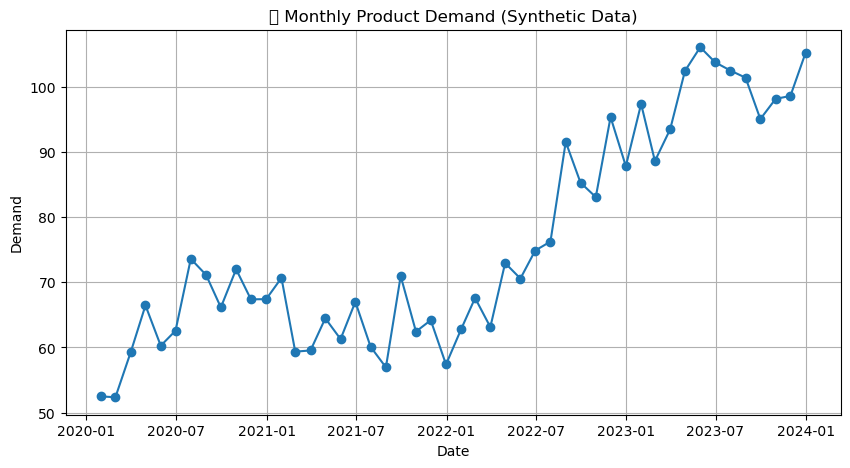

In [3]:
# 3. Visualize Data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Demand'], marker='o')
plt.title('📈 Monthly Product Demand (Synthetic Data)')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.grid(True)
plt.show()


In [ ]:
### 4. Stationarity Check
ARIMA requires **stationary data** (constant mean & variance over time).
We check this using the **Augmented Dickey-Fuller (ADF) test**.


In [5]:
from statsmodels.tsa.stattools import adfuller

# ADF test
adf_result = adfuller(df['Demand'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] > 0.05:
    print("❌ Data is NOT stationary — differencing needed.")
else:
    print("✅ Data is stationary.")


ADF Statistic: -0.6979495616446326
p-value: 0.8472799329786973
❌ Data is NOT stationary — differencing needed.


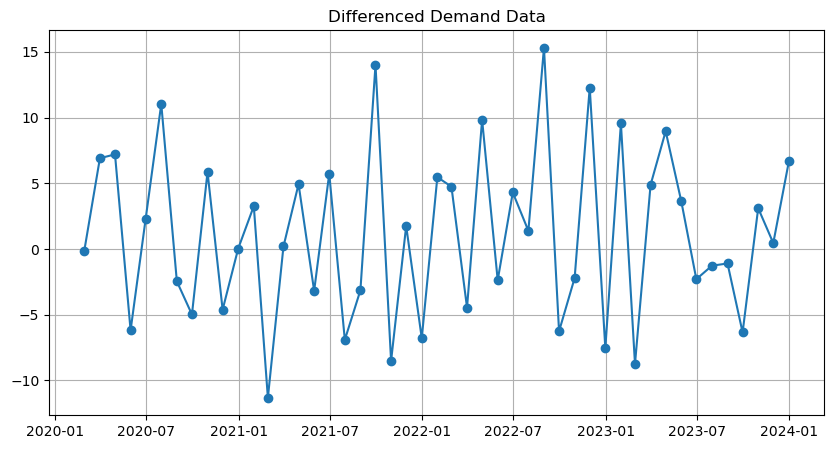

p-value after differencing: 3.0862065211636048e-18


In [7]:
# 5. Differencing if needed
df_diff = df['Demand'].diff().dropna()

plt.figure(figsize=(10, 5))
plt.plot(df_diff, marker='o')
plt.title('Differenced Demand Data')
plt.grid(True)
plt.show()

# Check again
adf_result_diff = adfuller(df_diff)
print("p-value after differencing:", adf_result_diff[1])


In [ ]:
### 6. Identify ARIMA Parameters (p, d, q)
- **p:** Number of AR terms → check PACF plot.
- **d:** Differencing order (already found above).
- **q:** Number of MA terms → check ACF plot.


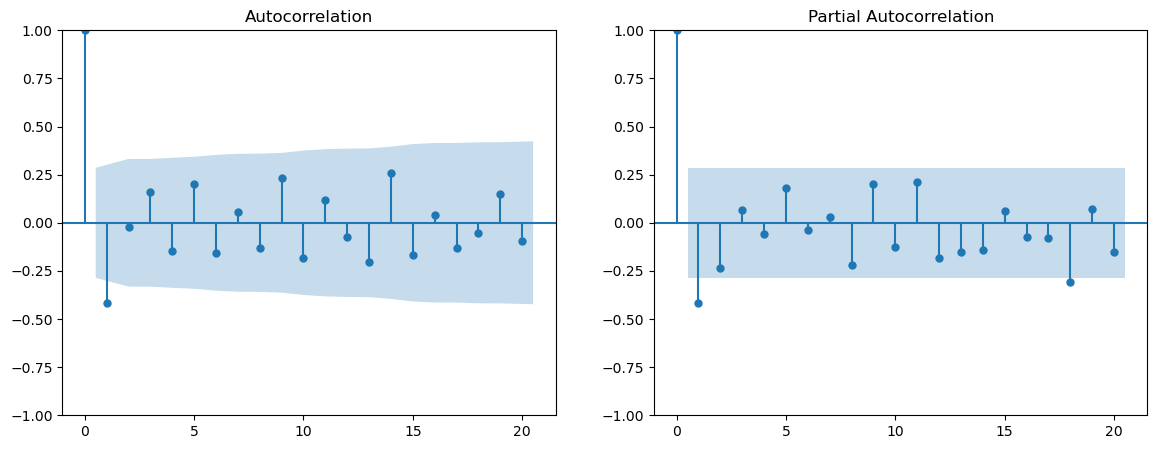

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df_diff, lags=20, ax=ax[0])
plot_pacf(df_diff, lags=20, ax=ax[1])
plt.show()


In [ ]:
From the plots:
- ACF cuts off after ~1 lag → **q ≈ 1**
- PACF cuts off after ~1 lag → **p ≈ 1**
- Differencing order `d = 1`

We will start with **ARIMA(1,1,1)**.

In [11]:
# 7. Build ARIMA Model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Demand'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Demand   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -150.879
Date:                Mon, 11 Aug 2025   AIC                            307.758
Time:                        19:23:36   BIC                            313.308
Sample:                    01-31-2020   HQIC                           309.846
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1917      0.467     -0.410      0.681      -1.107       0.724
ma.L1         -0.2324      0.458     -0.507      0.612      -1.130       0.666
sigma2        35.8259      7.535      4.755      0.0

In [ ]:
# 8. Forecast Future Demand
forecast_steps = 12  # next 12 months
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')

forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean,
    'Lower CI': forecast.conf_int()['lower Demand'],
    'Upper CI': forecast.conf_int()['upper Demand']
}, index=forecast_index)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Demand'], label='Historical Demand')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)
plt.title('ARIMA Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.show()
